In [1]:
# imports
import pandas as pd
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader
import shap 
import os

c:\Users\celin\miniconda3\envs\videogpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Q_vecDataset(torch.utils.data.Dataset):
        def __init__(self, X_rus, y_rus, train):
            self.feature = X_rus
            self.target = y_rus
            self.train = train

        def __len__(self):
            return self.target.shape[0]

        def __getitem__(self, index):
            X = self.feature.iloc[[index]]
            X = X.to_numpy()
            y = self.target.iloc[[index]]
            y= y.to_numpy()

            return X, y

In [8]:
def prepare_data():
    #os.chdir('../data')
    q_cleaned_old = pd.read_csv('data/mid_cleaning_240228.csv')
    q_cleaned_old.drop(['ia_status_Facility Study', 'ia_status_Feasibility Study',
        'ia_status_IA Executed', 'ia_status_Operational',
        'ia_status_System Impact Study', 'Unnamed: 0'], axis = 1, inplace=True)
    
    deregulated_electricity_markets = ['OR', 'CA', 'TX', 'IL', 'MI', 'OH', 'VA', 'MD', 'DE', 'PA', 'NJ', 'NY', 'MA', 'CT', 'RI', 'NH', 'ME']
    q_cleaned_old['is_deregulated'] = q_cleaned_old['state'].isin(deregulated_electricity_markets).astype(int)
    
    has_100_percent_clean_energy_goal = ['CA', 'CO', 'CT', 'DE', 'HI', 'IL', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NE', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OR', 'RI', 'VA', 'WA', 'WI']
    q_cleaned_old['has_100_clean_energy_goal'] = q_cleaned_old['state'].isin(has_100_percent_clean_energy_goal).astype(int)
    
    top_ten_renewable_generators = ['TX', 'FL', 'PA', 'CA', 'IL', 'AL', 'OH', 'NC', 'GA', 'NY']
    q_cleaned_old['top_ten_renewable_generators'] = q_cleaned_old['state'].isin(top_ten_renewable_generators).astype(int)
    
    
    q_cleaned_old['is_solar'] = (q_cleaned_old['type1_Solar'] == 1).astype(int)
    
    q_cleaned_old['is_storage'] = ((q_cleaned_old['type1_Battery'] == 1) |
                                    (q_cleaned_old['type1_Hydro'] == 1) |
                                    (q_cleaned_old['type1_Gravity Rail'] == 1) |
                                    (q_cleaned_old['type1_Flywheel'] == 1) |
                                    (q_cleaned_old['type1_Pumped Storage'] == 1)).astype(int)
    
    q_cleaned_old['is_wind'] = ((q_cleaned_old['type1_Offshore Wind'] == 1) |
                                (q_cleaned_old['type1_Wind'] == 1)).astype(int)

    q_cleaned_old['is_bioenergy'] = ((q_cleaned_old['type1_Biofuel'] == 1) |
                                    (q_cleaned_old['type1_Biogas'] == 1) |
                                    (q_cleaned_old['type1_Biomass'] == 1) |
                                    (q_cleaned_old['type1_Wood'] == 1)).astype(int)

    q_cleaned_old['is_wasteuse'] = ((q_cleaned_old['type1_Landfill'] == 1) |
                                    (q_cleaned_old['type1_Methane'] == 1) |
                                    (q_cleaned_old['type1_Waste Heat'] == 1)).astype(int)

    q_cleaned_old['is_cleanenergy'] = ((q_cleaned_old['type1_Geothermal'] == 1) |
                                    (q_cleaned_old['type1_Nuclear'] == 1) |
                                    (q_cleaned_old['type1_Solar'] == 1) |
                                    (q_cleaned_old['type1_Offshore Wind'] == 1) |
                                    (q_cleaned_old['type1_Hydro'] == 1) |
                                    (q_cleaned_old['type1_Wind'] == 1)).astype(int)

    q_cleaned_old['is_fossilfuels'] = ((q_cleaned_old['type1_Coal'] == 1) |
                                    (q_cleaned_old['type1_Diesel'] == 1) |
                                    (q_cleaned_old['type1_Gas'] == 1) |
                                    (q_cleaned_old['type1_Oil'] == 1) |
                                    (q_cleaned_old['type1_Steam'] == 1)).astype(int)

    q_cleaned_old['is_hybrid'] = (q_cleaned_old['type1_Hybrid'] == 1).astype(int)
    
    high_revenue_utilities = ['SOCO', 'Duke Energy Indiana, LLC', 'Duke_FL','Duke Energy Corporation',
                              'Duke Energy', 'Duke', 'PGE', 'AEP', 'DominionSC', 'Dominion SC', 'Dominion']
    q_cleaned_old['high_revenue_utility'] = q_cleaned_old['utility'].isin(high_revenue_utilities).astype(int)
    
    q_cleaned_old.drop(['q_date', 'state', 'entity', 'utility', 'county_1'], axis = 1, inplace=True)
    q_cleaned_old.drop(['Join_Count','Join_Count_1','Join_Count_12','TARGET_FID_12','Join_Count_12_13','TARGET_FID_12_13'], axis = 1, inplace=True)
    q_cleaned_old.drop(['name', 'power', 'substation', 'type', 'LEGAL_NAME', 'tokens.1'], axis = 1, inplace=True)
    
    print(q_cleaned_old.info())
    print(q_cleaned_old.describe())
    
    exempt = []
    for col in list(q_cleaned_old.columns):
        if q_cleaned_old[col].max() < 1:
            exempt.append(col)
        if 'type1' in col:
            exempt.append(col)
    q_cleaned_old.drop(columns = exempt, inplace=True)
    
    q_cleaned_old.rename(columns={'q_year': 'year_entering_queue', 
                'prop_year': 'proposed_year',
                'total_mw': 'project_size_mw',
                'Lat': 'project_latitude',
                'Long': 'project_longitude',
                'POP_SQMI': 'population_density',
                'votes_per_sqkm': 'voting_density',
                'solar_ann_ghi_rn': 'solar_potential',
                'avg_wind_speed_meters_per_second': 'wind_potential'}, inplace=True)
    
    # Use batch normalization here - subtract by mean of data + divide by variance
    scaler = StandardScaler()
    scaler.fit(q_cleaned_old)
    q_cleaned_array = scaler.transform(q_cleaned_old)
    q_cleaned = pd.DataFrame(q_cleaned_array, columns=q_cleaned_old.columns)
    

    features = q_cleaned.drop(['ia_status_Withdrawn'], axis = 1)
    target = q_cleaned_old['ia_status_Withdrawn']

    seed = 42

    rus = RandomUnderSampler(random_state=seed)
    X_rus, y_rus= rus.fit_resample(features, target)
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                            test_size = 0.2,
                                                            random_state = seed)
    return X_train, X_test, y_train, y_test

 

In [5]:
%pwd

'c:\\Users\\celin\\git\\Quennect\\src'

In [6]:
%cd ..

c:\Users\celin\git\Quennect


In [27]:
input_dim=29

In [49]:
# class NeuralNetwork(nn.Module): # nn.Module = base case for all neural network modules
#     # we define model as a subclass of nn.Module -> it creates parameters of the modules with utility methods like eval()
#         def __init__(self):
#             super().__init__()
#             self.flatten = nn.Flatten()
#             self.linear_relu_stack = nn.Sequential(
#                 nn.Linear(input_dim, int(128)), # apply linear transformation to the incoming data : y = x*W^T+b
#                                         # weight here will be size of output * input
#                 nn.ReLU(),  # rectified linear unit function: 0 for values < 0 and linear function if > 0
#                 nn.Linear(int(128), int(64)),
#                 nn.ReLU(),
#                 nn.Linear(64, 32),
#                 nn.ReLU(),
#                 nn.Linear(32, 64),
#                 nn.ReLU(),
#                 nn.Linear(64, 2),
#             )
#             #self.sig = nn.Sigmoid() 
#             #self.softmax = nn.Softmax(dim=1)
#             # TODO: BCELoss does not expect raw logits - every value should be in the range [0,1].
#             # TODO: Check what the previous model was doing, if there was regularization, learning rate, etc.
            
#         def forward(self, x): 
#             x = self.flatten(x) # collapse into one dimensions
#             x = self.linear_relu_stack(x)
#             return x # changed to squeeze

In [11]:
class NeuralNetwork(nn.Module): # nn.Module = base case for all neural network modules
    # we define model as a subclass of nn.Module -> it creates parameters of the modules with utility methods like eval()
        def __init__(self):
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(29, int(128)), # apply linear transformation to the incoming data : y = x*W^T+b
                                        # weight here will be size of output * input
                nn.ReLU(),  # rectified linear unit function: 0 for values < 0 and linear function if > 0
                nn.Linear(int(128), int(64)),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
            )
            #self.sig = nn.Sigmoid() 
            #self.softmax = nn.Softmax(dim=1)
            # TODO: BCELoss does not expect raw logits - every value should be in the range [0,1].
            # TODO: Check what the previous model was doing, if there was regularization, learning rate, etc.
            
        def forward(self, x): 
            x = self.linear_relu_stack(x)
            #x = self.sig(x)
            #x = self.softmax(x)
            return x # changed to squeeze

In [12]:
filepath = os.path.join("data", "model", "epoch5_lime_woutil.pt")
the_model = NeuralNetwork()
the_model = torch.load(filepath)

In [45]:
# filepath = os.path.join("model", "epoch5_lime.pt")
# the_model = NeuralNetwork()
# the_model = torch.load(filepath)

In [13]:
the_model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=29, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [22]:
def model_wrapper(x):
        with torch.no_grad():
            x_tensor = torch.FloatTensor(x).to(device)
            predictions = the_model(x)
            return(predictions.cpu().to_numpy())

In [10]:
shap.initjs()      

In [9]:
X_train, X_test, y_train, y_test = prepare_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5480 entries, 0 to 5479
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   q_year                            5480 non-null   float64
 1   prop_year                         5480 non-null   float64
 2   region_CAISO                      5480 non-null   int64  
 3   region_ERCOT                      5480 non-null   int64  
 4   region_ISO-NE                     5480 non-null   int64  
 5   region_MISO                       5480 non-null   int64  
 6   region_NYISO                      5480 non-null   int64  
 7   region_PJM                        5480 non-null   int64  
 8   region_SPP                        5480 non-null   int64  
 9   region_Southeast (non-ISO)        5480 non-null   int64  
 10  region_West (non-ISO)             5480 non-null   int64  
 11  total_mw                          5480 non-null   float64
 12  type1_

In [18]:
device = "cpu"

In [39]:
len(X_train)

920

In [38]:
len(X_test)

230

In [45]:
X_test

,year_entering_queue,proposed_year,region_CAISO,region_MISO,region_PJM,region_Southeast (non-ISO),region_West (non-ISO),project_size_mw,project_latitude,population_density,...,top_ten_renewable_generators,is_solar,is_storage,is_wind,is_bioenergy,is_wasteuse,is_cleanenergy,is_fossilfuels,is_hybrid,high_revenue_utility
5084,-0.778185,-1.094768,-0.42817,-0.521020,0.950494,-0.178384,-0.285496,-0.616488,0.032954,2.326012,...,-0.981557,1.001095,-0.361704,-0.447997,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
1306,0.949854,0.534555,-0.42817,-0.521020,-1.052085,5.605893,-0.285496,-0.597235,-1.895463,-0.538737,...,-0.981557,-0.998906,2.764694,-0.447997,-0.087883,-0.133531,-1.476651,-0.452101,-0.038236,2.716469
827,0.949854,0.860419,2.33552,-0.521020,-1.052085,-0.178384,-0.285496,0.034260,0.028156,-0.313678,...,1.018790,1.001095,-0.361704,-0.447997,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
1808,-1.469400,-1.420633,-0.42817,-0.521020,0.950494,-0.178384,-0.285496,0.138225,0.512404,-0.374693,...,1.018790,-0.998906,-0.361704,2.232159,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
1101,0.604246,0.534555,-0.42817,-0.521020,-1.052085,-0.178384,3.502680,-0.366200,0.422044,-0.908037,...,-0.981557,1.001095,-0.361704,-0.447997,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,-1.123793,-1.257701,2.33552,-0.521020,-1.052085,-0.178384,-0.285496,-0.346947,-1.659627,-0.313678,...,1.018790,1.001095,-0.361704,-0.447997,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
3998,0.777050,1.023352,-0.42817,-0.521020,0.950494,-0.178384,-0.285496,-0.250683,0.687108,-0.214931,...,1.018790,1.001095,-0.361704,-0.447997,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125
5203,-2.851831,-2.561159,-0.42817,-0.521020,0.950494,-0.178384,-0.285496,0.057363,0.327690,2.326012,...,-0.981557,-0.998906,-0.361704,-0.447997,-0.087883,-0.133531,-1.476651,2.211894,-0.038236,-0.368125
113,-0.605381,-1.257701,-0.42817,1.919313,-1.052085,-0.178384,-0.285496,-0.366200,0.753347,-0.831501,...,-0.981557,-0.998906,-0.361704,2.232159,-0.087883,-0.133531,0.677208,-0.452101,-0.038236,-0.368125


In [19]:
background_data =  X_train.to_numpy()
background_data_tensor = torch.FloatTensor(background_data).to(device)  # Convert background data to tensor

test_data_numpy = X_test.to_numpy()
test_data_tensor = torch.tensor(test_data_numpy, dtype=torch.float).to(device)

In [53]:
the_model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=29, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [20]:
explainer = shap.GradientExplainer(the_model, background_data_tensor)
#explainer = shap.GradientExplainer(the_model, background_data)

In [30]:
shap_values = explainer.shap_values(background_data_tensor)

In [62]:
shap_values_test = explainer.shap_values(test_data_tensor)

In [66]:
shap_values_test2 = explainer(test_data_tensor)

In [23]:
feature_names = X_test.columns

In [24]:
print(list(feature_names))

['year_entering_queue', 'proposed_year', 'region_CAISO', 'region_MISO', 'region_PJM', 'region_Southeast (non-ISO)', 'region_West (non-ISO)', 'project_size_mw', 'project_latitude', 'population_density', 'votes_dem', 'votes_rep', 'votes_total', 'voting_density', 'pct_dem_lead', 'solar_potential', 'wind_potential', 'is_deregulated', 'has_100_clean_energy_goal', 'top_ten_renewable_generators', 'is_solar', 'is_storage', 'is_wind', 'is_bioenergy', 'is_wasteuse', 'is_cleanenergy', 'is_fossilfuels', 'is_hybrid', 'high_revenue_utility']


In [31]:
shap_values_0 = shap_values[0]

In [93]:
shap_values_test2.data[5]

tensor([ 0.4314,  0.6975, -0.4282, -0.5210,  0.9505, -0.1784, -0.2855, -0.5895,
         0.2980, -0.2149, -0.1961, -0.1632, -0.2018, -0.3919, -0.2270, -0.7997,
        -0.4073,  0.6643, -1.1662,  1.0188,  1.0011, -0.3617, -0.4480, -0.0879,
        -0.1335,  0.6772, -0.4521, -0.0382, -0.3681])

In [118]:
shap_values_test2.values[1][5]

array([ 1.29618861e-02,  3.25212561e-03,  6.08330995e-03,  9.78520260e-03,
        7.84542433e-03, -1.10331034e-01, -8.06739786e-02, -6.03446914e-03,
       -1.90067428e-02, -1.30836657e-03,  1.02674177e-03,  2.47067846e-04,
        2.13723022e-05, -1.71845717e-04, -3.88971250e-03, -3.73192714e-02,
        8.15472522e-03, -6.61394492e-02, -2.85073231e-02, -4.94909046e-02,
        1.00610957e-02,  4.73066017e-03,  5.45680718e-03,  2.61897139e-03,
        2.52957649e-04,  1.59313289e-03,  7.54943904e-03,  0.00000000e+00,
       -5.60559400e-02])

In [95]:
exp = shap.Explanation(shap_values_test2.values[:][0], shap_values_test2.data[0], feature_names = feature_names)

TypeError: len() of a 0-d tensor

In [33]:
print(shap_values_0.shape)
print(shap_values_0[:,0])

(920, 29)
[ 4.42991171e-03  1.12365794e-02 -5.14058554e-02 -1.81780350e-02
 -2.32203468e-02 -2.62228300e-02 -8.17115614e-02  8.18050577e-03
 -4.32655756e-02  4.48774709e-02 -4.21309933e-02 -2.47260440e-02
  7.47353313e-02  8.53503777e-02 -2.43039660e-02 -3.96415980e-02
 -3.00486010e-02 -1.50308077e-02  9.79954650e-02 -5.32422963e-02
  8.31878810e-03  1.03448288e-01 -4.87716673e-02 -5.13489367e-02
  7.11086966e-02  2.46338444e-02 -2.11593244e-02  3.06280163e-02
 -2.58379226e-02 -9.42406329e-02 -3.12266916e-02  7.84018103e-02
 -2.56763835e-02  2.06929488e-03 -4.21761099e-02 -5.24561024e-02
 -3.14275907e-02 -1.44696903e-02 -5.45172878e-04  6.86601485e-02
  1.23772748e-02  6.59521428e-02 -9.46695134e-03  1.34224104e-02
 -3.06132670e-02 -6.95385371e-02 -1.91113593e-02 -5.73738774e-02
 -5.63176912e-02 -5.99554397e-02 -4.33557884e-02 -6.66232680e-03
 -1.39547604e-02 -6.54715511e-02 -3.37318311e-02  7.16105688e-02
  3.11016701e-02 -2.81381374e-02 -2.39006158e-02  5.98422289e-02
  2.73269970e-0

In [58]:
shap_values_test_0 = shap_values_test[0]

In [120]:
shap.plots.waterfall(shap_values_test2[0], max_display=14)

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (230, 29)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

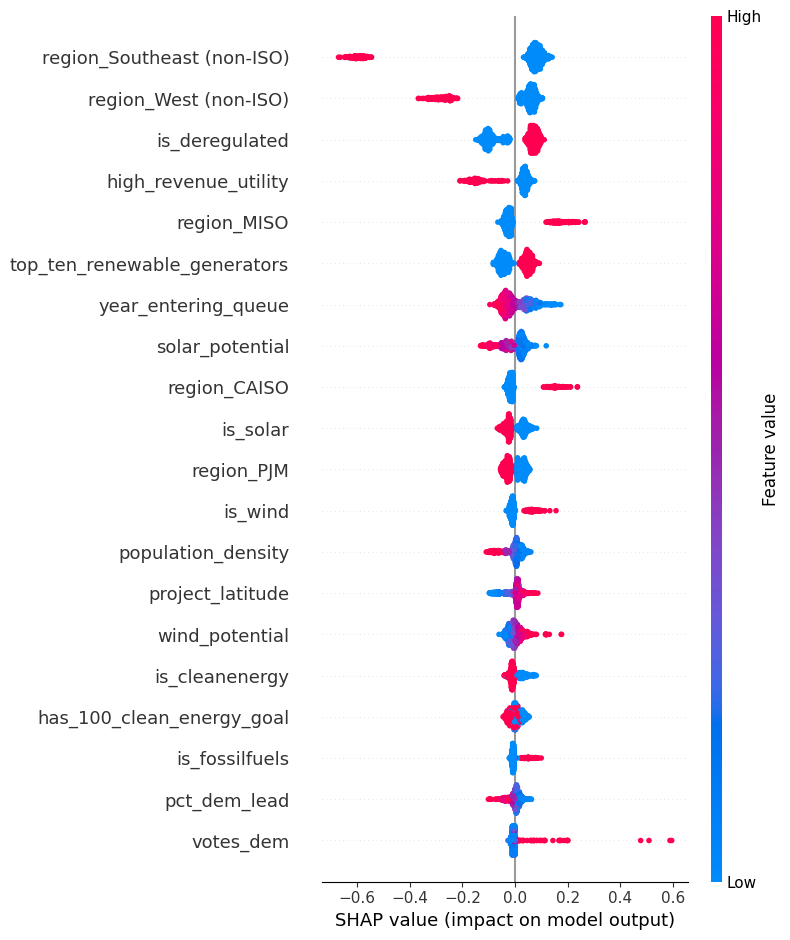

In [28]:
shap.summary_plot(shap_values, X_train)